In [ ]:
pip install torch gym matplotlib


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1/1000, Total Reward: 39.0
Episode 101/1000, Total Reward: 11.0
Episode 201/1000, Total Reward: 10.0
Episode 301/1000, Total Reward: 33.0
Episode 401/1000, Total Reward: 28.0
Episode 501/1000, Total Reward: 106.0
Episode 601/1000, Total Reward: 148.0
Episode 701/1000, Total Reward: 65.0
Episode 801/1000, Total Reward: 192.0
Episode 901/1000, Total Reward: 81.0


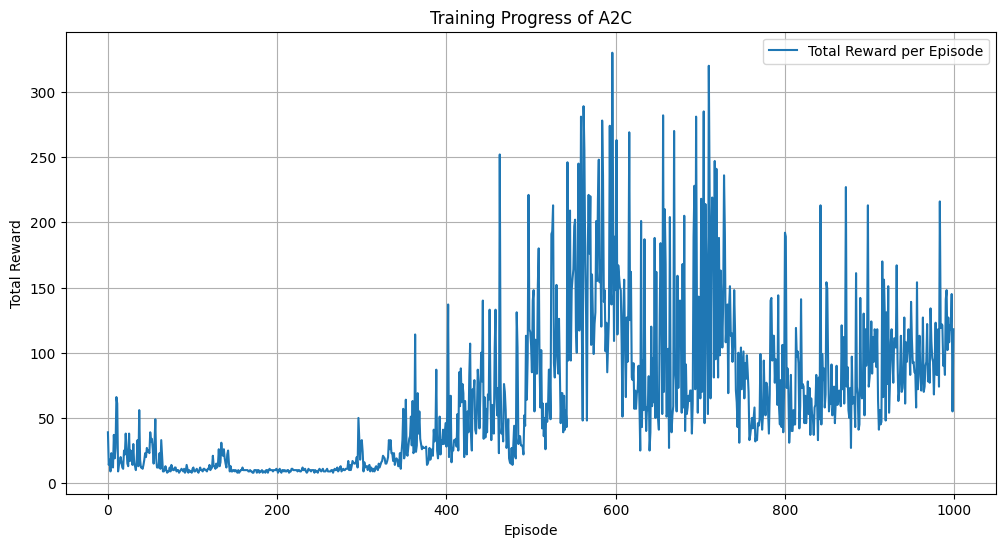

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt

# Define the Actor-Critic Network
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.policy_head = nn.Linear(128, action_dim)
        self.value_head = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.policy_head(x), self.value_head(x)

# Advantage Actor-Critic (A2C) Algorithm
class A2C:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99):
        self.gamma = gamma
        self.actor_critic = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr)

    def select_action(self, state):
        state = torch.FloatTensor(state)
        policy_logits, _ = self.actor_critic(state)
        action_probs = torch.softmax(policy_logits, dim=-1)
        action = torch.multinomial(action_probs, num_samples=1)
        return action.item()

    def update(self, memory):
        states, actions, rewards, next_states, dones = zip(*memory)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        # Calculate advantages
        _, values = self.actor_critic(states)
        _, next_values = self.actor_critic(next_states)

        td_targets = rewards + self.gamma * next_values.squeeze() * (1 - dones)
        advantages = td_targets - values.squeeze()

        # Update policy
        policy_logits, _ = self.actor_critic(states)
        action_probs = torch.softmax(policy_logits, dim=-1)
        log_probs = torch.log(action_probs.gather(1, actions.unsqueeze(1)).squeeze())

        actor_loss = -log_probs * advantages.detach()  # Policy loss
        critic_loss = nn.MSELoss()(values.squeeze(), td_targets.detach())  # Value loss

        self.optimizer.zero_grad()
        (actor_loss + critic_loss).mean().backward()  # Combined loss
        self.optimizer.step()

# Main training loop
def train_a2c(env_name='CartPole-v1', num_episodes=1000):
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    a2c_agent = A2C(state_dim, action_dim)

    total_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        memory = []
        done = False
        total_reward = 0

        while not done:
            action = a2c_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            memory.append((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward

        a2c_agent.update(memory)
        total_rewards.append(total_reward)

        if episode % 100 == 0:
            print(f'Episode {episode + 1}/{num_episodes}, Total Reward: {total_reward}')

    env.close()

    # Plotting the total rewards
    plt.figure(figsize=(12, 6))
    plt.plot(total_rewards, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress of A2C')
    plt.legend()
    plt.grid()
    plt.show()

# Run the A2C training
train_a2c()
